**ALEXNET IMPLEMENTATION PYTORCH**


***1. LOADING IMPORTANT LIBRARIES***

In [34]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

***2. LOADING AND PREPARING THE DATASET***

In [37]:
#creating a dinstinct transform class for the train, validation and test dataset
tranform_train = transforms.Compose([transforms.Resize((227,227)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((227,227)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = CIFAR10("data/", train=True, download=True, transform=tranform_train) #40,000 original images + transforms
val_size = 10000 #there are 10,000 test images and since there are no transforms performed on the test, we keep the validation as 10,000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) #Extracting the 10,000 validation images from the train set
test_ds = CIFAR10("data/", train=False, download=True, transform=tranform_test) #10,000 images

#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


***2.1. PREVIEWING THE TRAIN DATASET***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


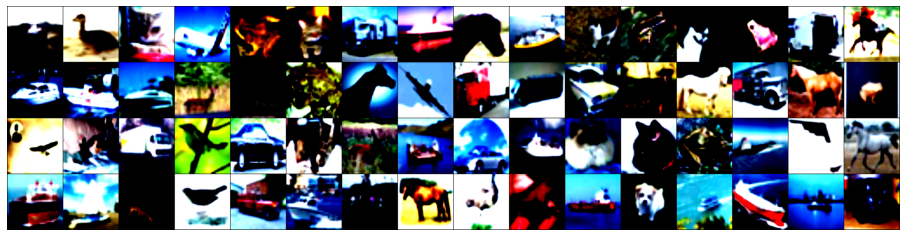

In [38]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

***2.2. PREVIEWING THE TEST DATASET***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


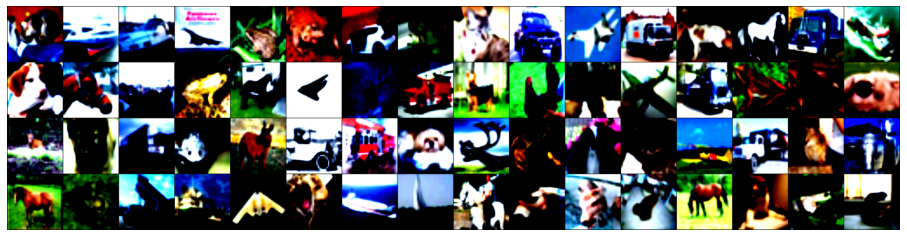

In [40]:
for images, _ in test_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

***2.3. PREVIEWING THE VAL DATASET***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


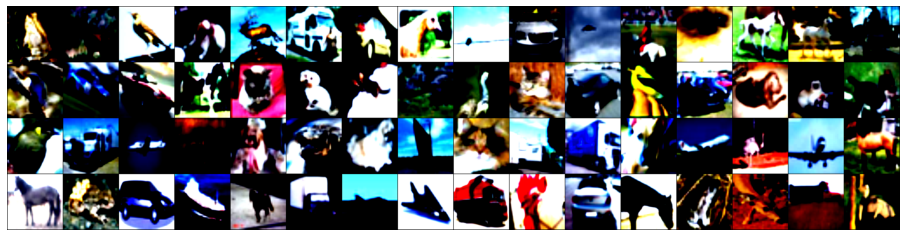

In [41]:
for images, _ in val_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

***3. BUILDING THE MODEL***

In [42]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

***4. PREPARE THE MODEL FOR TRAINING***

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

model = AlexNet() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = 1e-4 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning

***5. TRAINING***

In [45]:
for epoch in range(50): #I decided to train the model for 50 epochs
    loss_ep = 0
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss in epoch 0 :::: 1.51535515127182
Got 5463 / 10000 with accuracy 54.63
Loss in epoch 1 :::: 1.005184255218506
Got 6814 / 10000 with accuracy 68.14
Loss in epoch 2 :::: 0.762190770149231
Got 7488 / 10000 with accuracy 74.88
Loss in epoch 3 :::: 0.6180435956478119
Got 7777 / 10000 with accuracy 77.77
Loss in epoch 4 :::: 0.5024404588222504
Got 7978 / 10000 with accuracy 79.78
Loss in epoch 5 :::: 0.4075883430480957
Got 7845 / 10000 with accuracy 78.45
Loss in epoch 6 :::: 0.32922786853313446
Got 8049 / 10000 with accuracy 80.49
Loss in epoch 7 :::: 0.2571961438775063
Got 8108 / 10000 with accuracy 81.08
Loss in epoch 8 :::: 0.20070381747484206
Got 8050 / 10000 with accuracy 80.50
Loss in epoch 9 :::: 0.1599851725548506
Got 8189 / 10000 with accuracy 81.89
Loss in epoch 10 :::: 0.1319416419148445
Got 8187 / 10000 with accuracy 81.87
Loss in epoch 11 :::: 0.1098332383789122
Got 8213 / 10000 with accuracy 82.13
Loss in epoch 12 :::: 0.09530828564316034
Got 8264 / 10000 with accuracy 82.

***6.SAVING THE MODEL AND USING IT FOR THE TEST SET***

In [46]:
torch.save(model.state_dict(), "alexnet_cifar.pt") #SAVES THE TRAINED MODEL

In [47]:
model = AlexNet()
model.load_state_dict(torch.load("/content/alexnet_cifar.pt")) #loads the trained model
model.eval()

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

***7. TESTING***

In [48]:
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_dl):
    data = data.to(device="cpu")
    targets = targets.to(device="cpu")
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(
    f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
)

Got 8211 / 10000 with accuracy 82.11
